# CubeML prototyping

## Load libraries and get ready...

In [1]:
cd ../

/media/gmobot/data/NSF_GWAS/notebooks/Broadband/cubeml


In [2]:
#pip install deap

In [3]:
import pickle
import spectral
#spectral.settings.envi_support_nonlowercase_params = True
from cubeml import TrainingData
from cubeml import CubeSchool
from cubeml.model_evaluation import presentable_table
from cubeml.model_evaluation import generate_falsecolor_images
from cubeml.model_evaluation import compare_inferences
from cubeml.model_evaluation import match_files
import os

In [4]:
json_file = '../03_Parse_labels_and_train/labels_a2_halogena1/project-2-at-2023-06-07-03-09-cee8e3b6.json'

hypercube_dir = "../02_False_color_development/poplar_regen_halogen_a1/"

png_directory = "../03_Parse_labels_and_train/labels_a2_halogen_png/"

In [5]:
falsecolor_dir = "output/falsecolor/"
learner_plot_dir = "output/learner_plots/"
panel_image_dir = "output/panel_images/"

## Prepare models

In [6]:
[os.makedirs(dir, exist_ok=True) for dir in [falsecolor_dir, learner_plot_dir, panel_image_dir]]

[None, None, None]

### Build `TrainingData`

In [7]:
training_data = TrainingData(
    json_file=json_file,
    img_directory=hypercube_dir,
    png_directory=png_directory,
    normalize_features=True
)

training_data.stratified_sample()

filename = "output/" + os.path.basename(os.path.normpath(png_directory.replace('/', '_TrainingData.pkl')))
pickle.dump(training_data, open(filename, 'wb'))

load mode isload_full_then_crop


/home/gmobot/anaconda3/envs/cubeglm2/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


load mode isload_full_then_crop
load mode isload_full_then_crop
load mode isload_full_then_crop
load mode isload_full_then_crop
load mode isload_full_then_crop
load mode isload_full_then_crop
load mode isload_full_then_crop
load mode isload_full_then_crop
load mode isload_full_then_crop
load mode isload_full_then_crop
load mode isload_full_then_crop
load mode isload_full_then_crop
load mode isload_full_then_crop
load mode isload_full_then_crop
load mode isload_full_then_crop
load mode isload_full_then_crop
load mode isload_full_then_crop
load mode isload_full_then_crop


In [8]:
training_data.labels_key_df

,Label,Integer
0,background,0
1,callus,1
2,shoot,2
3,stem_healthy,3
4,stem_necrotic,4


In [9]:
colors = ['#000000', '#0000FF', '#013220', '#FF0000', '#964B00']  # User-provided color list

## AutoML to optimize RF, DTC and GBC

In [10]:
from scipy.optimize import minimize
from cubeml import CubeLearner
import numpy as np

In [ ]:
model_types = ["RF", "GBC", "DTC"]
data_types = ["Train", "Test"]

# Initialize dictionaries to store learners, cfx, and iou
learner_dict = {}
cfx_dict = {data_type: {} for data_type in data_types}
iou_dict = {data_type: {model_type: [] for model_type in model_types} for data_type in data_types} 

for model_type in model_types:
    # Instantiate CubeLearner and store in dictionary
    learner_dict[model_type] = CubeLearner(training_data, model_type=model_type, colors=colors, train_test=True if model_type != "PCA" else False)

    # Fit the model using automl
    if model_type in ["RF", "DTC", "GBC"]:
        # First run Grid Search to optimize parameters
        learner_dict[model_type].fit(automl="grid")
        print(f"Grid Search optimal parameters for {model_type}: ", learner_dict[model_type].optimal_params)

        # Check if optimal_parameters is not None before passing to Gradient Descent
        if learner_dict[model_type].optimal_params:
            # Pass the Grid Search optimized parameters to Gradient Descent for further optimization
            param_ranges = {}
            for k, v in learner_dict[model_type].optimal_params.items():
                param_type = type(learner_dict[model_type].model.get_params()[k]) # Getting the type of parameter from the original model

                if isinstance(v, int) and param_type in [int, np.int32, np.int64]:  # If parameter is integer
                    param_ranges[k] = (int(0.8 * v), int(1.2 * v)) # adjust range as required
                elif isinstance(v, float) and param_type in [float, np.float32, np.float64]: # If parameter is float
                    param_ranges[k] = (0.8 * v, 1.2 * v)  # adjust range as required
                elif isinstance(v, str) or v is None:  # If parameter is a string or None
                    param_ranges[k] = [v]  # use list with single value

            learner_dict[model_type].fit(automl="genetic", param_ranges=param_ranges)
            print(f"Genetic-based optimal parameters for {model_type}: ", learner_dict[model_type].optimal_params)
        else:
            print(f"No optimal parameters found from Grid Search for {model_type}, skipping Gradient Descent.")


    else: 
        learner_dict[model_type].fit()
    
    for data_type in data_types:
        # Plot the results
        learner_dict[model_type].visualize(data_type)
        
        if model_type != "PCA":  
            # Calculate and store cfx and iou
            learner_dict[model_type].plot_cfx(data_type)
            cfx_dict[data_type][model_type] = learner_dict[model_type].cfx_train if data_type == "Train" else learner_dict[model_type].cfx_test 
            
            # Assign the IoU dictionary to the appropriate key
            iou_dict[data_type][model_type] = learner_dict[model_type].iou_dict_train if data_type == "Train" else learner_dict[model_type].iou_dict_test

Debugging here
Running grid search with default param distributions


In [12]:
param_ranges

{'criterion': ['entropy'],
 'max_depth': (16, 24),
 'max_features': ['sqrt'],
 'min_samples_leaf': (8, 12),
 'min_samples_split': (40, 60),
 'n_estimators': (120, 180)}

In [ ]:
# Started around 4pm

In [12]:
param_ranges

{'criterion': ('entropy', 'entropy'),
 'max_depth': (16.0, 24.0),
 'max_features': ('sqrt', 'sqrt'),
 'min_samples_leaf': (8.0, 12.0),
 'min_samples_split': (40.0, 60.0),
 'n_estimators': (120.0, 180.0)}

In [13]:
learner_dict.items()

dict_items([('RF', <cubeml.cube_learner.CubeLearner object at 0x7fd7d4bebc10>), ('GBC', <cubeml.cube_learner.CubeLearner object at 0x7fd90c2e4b20>)])

### Build `CubeLearner` objects inside `CubeSchool`

Train data confusion matrices for each class: {0: array([13875,    42,     6,    13,   173]), 1: array([ 728, 9671,   31, 3331,  348]), 2: array([  173,    67, 12645,  1215,     9]), 3: array([  158,  2314,    43, 11449,   144]), 4: array([  305,    42,     0,   558, 13204])}
Test data confusion matrices for each class: {0: array([3466,   15,    0,    2,   44]), 1: array([ 183, 2387,   13,  833,  111]), 2: array([  51,   11, 3154,  307,    4]), 3: array([  42,  598,   11, 2840,   37]), 4: array([  80,   13,    0,  147, 3287])}
Train data confusion matrices for each class: {0: array([14019,    55,     0,     1,    34]), 1: array([  108, 11328,   430,  1913,   330]), 2: array([   23,   215, 13174,   674,    23]), 3: array([  153,  1800,   126, 11922,   107]), 4: array([   84,    31,     0,   121, 13873])}
Test data confusion matrices for each class: {0: array([3499,   12,    0,    0,   16]), 1: array([  43, 2756,  130,  496,  102]), 2: array([   9,   53, 3281,  182,    2]), 3: array([  3

/home/gmobot/anaconda3/envs/cubeglm2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train data confusion matrices for each class: {0: array([13778,    21,    11,     7,   292]), 1: array([  31, 9370,  252, 3661,  795]), 2: array([    5,    94, 13330,   677,     3]), 3: array([   41,  2918,   217, 10761,   171]), 4: array([  225,    34,     0,   528, 13322])}
Test data confusion matrices for each class: {0: array([3442,   10,    4,    2,   69]), 1: array([   9, 2366,   67,  879,  206]), 2: array([   4,   24, 3328,  171,    0]), 3: array([   5,  722,   53, 2705,   43]), 4: array([  68,    8,    0,  145, 3306])}
Train data confusion matrices for each class: {0: array([5589,  293,    7,   63, 8157]), 1: array([ 323, 6555, 1010, 5099, 1122]), 2: array([ 197, 1045, 9542, 2872,  453]), 3: array([  235,  1611,    92, 10856,  1314]), 4: array([   33,    28,     0,  1587, 12461])}
Test data confusion matrices for each class: {0: array([1400,   62,    0,   14, 2051]), 1: array([  85, 1654,  265, 1235,  288]), 2: array([  56,  266, 2346,  754,  105]), 3: array([  59,  385,   22, 

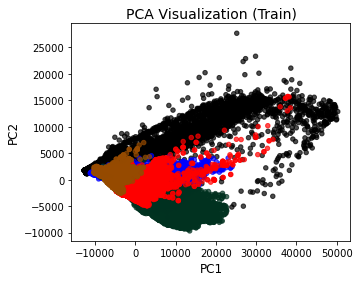

PCA

Results shape: (88180, 2)
Labels shape: (88180,)



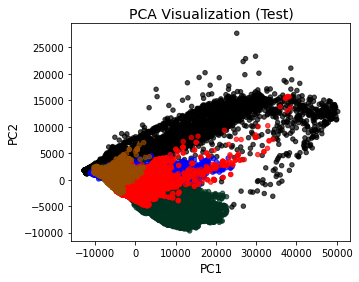

Train

Results shape: (70544, 4)
Labels shape: (70544,)



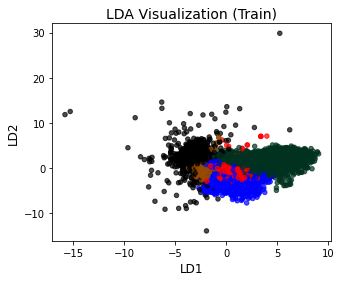

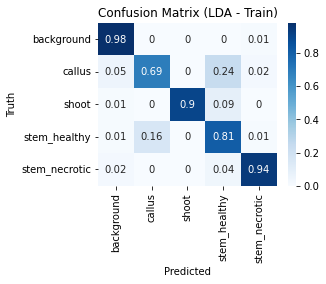

Test

Results shape: (17636, 4)
Labels shape: (17636,)



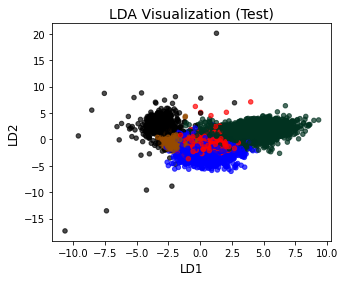

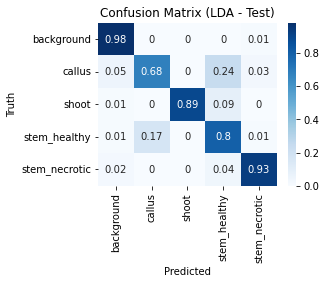

Train

Results shape: (70544,)
Labels shape: (70544,)



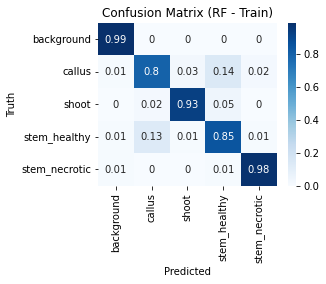

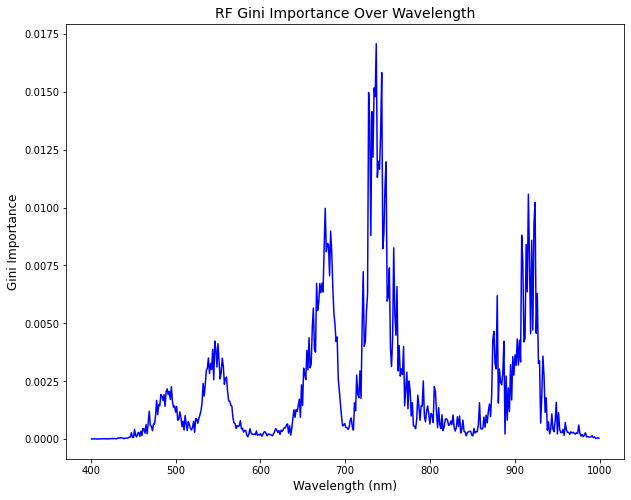

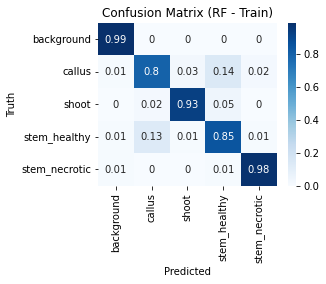

Test

Results shape: (17636,)
Labels shape: (17636,)



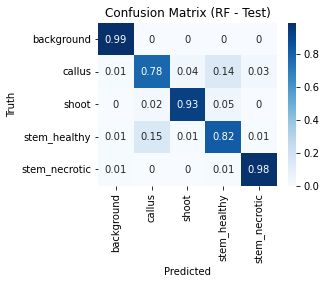

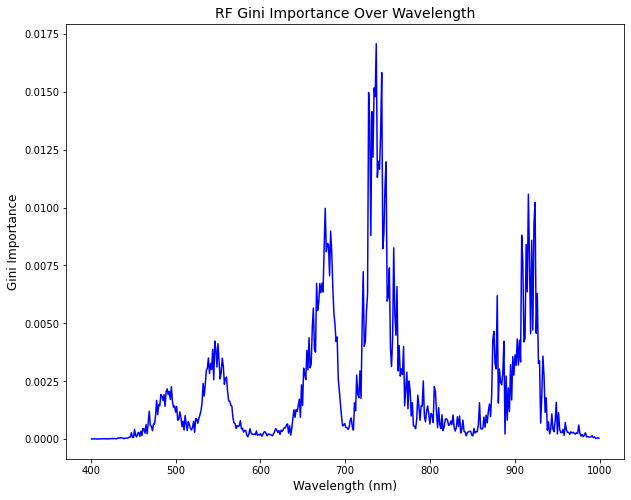

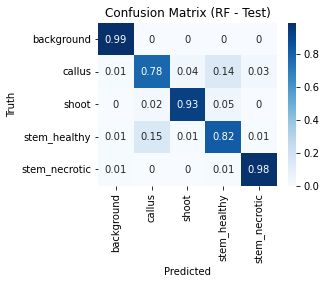

Train

Results shape: (70544,)
Labels shape: (70544,)



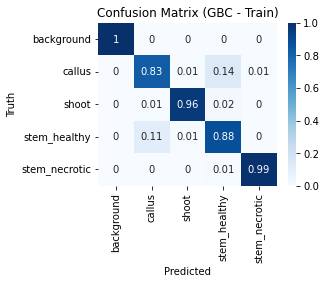

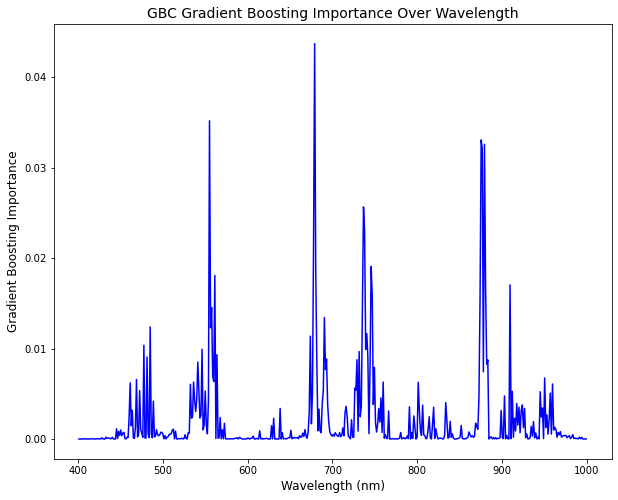

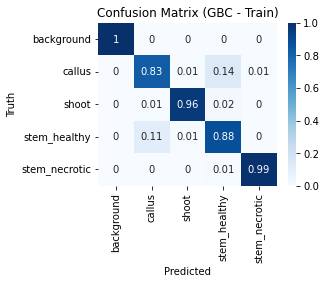

Test

Results shape: (17636,)
Labels shape: (17636,)



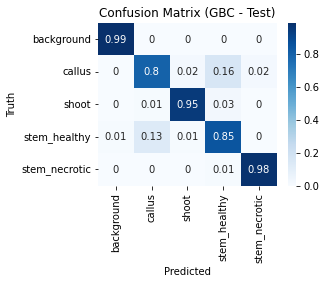

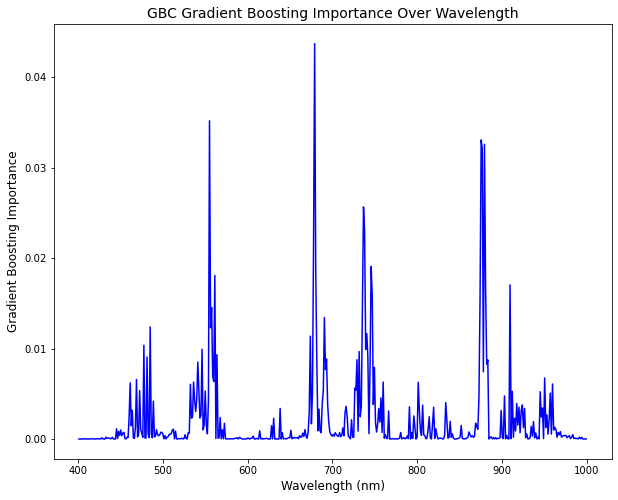

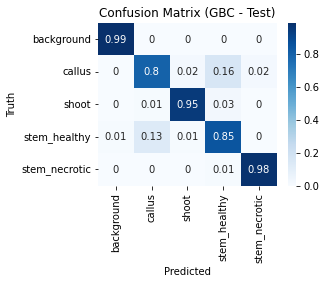

Train

Results shape: (70544,)
Labels shape: (70544,)



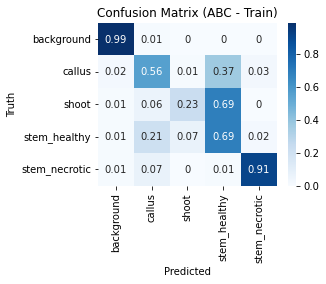

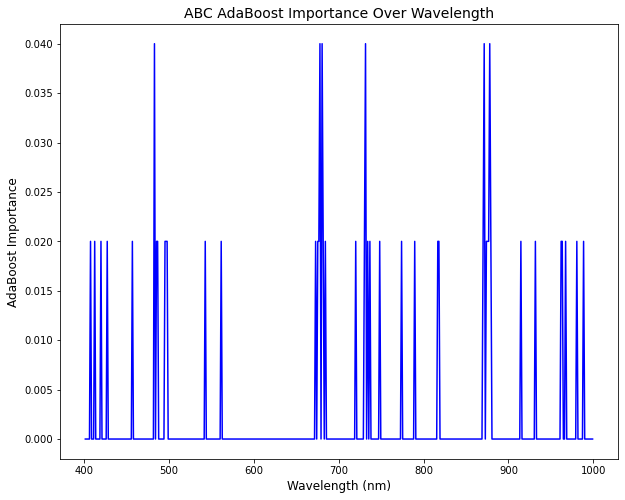

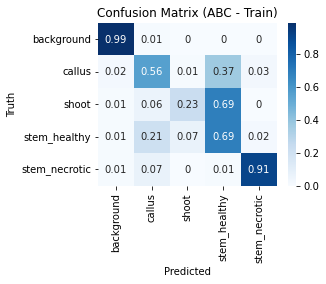

Test

Results shape: (17636,)
Labels shape: (17636,)



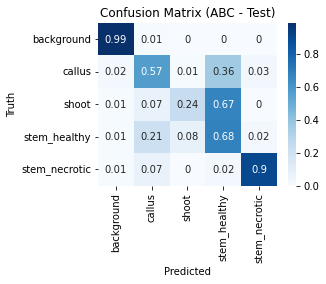

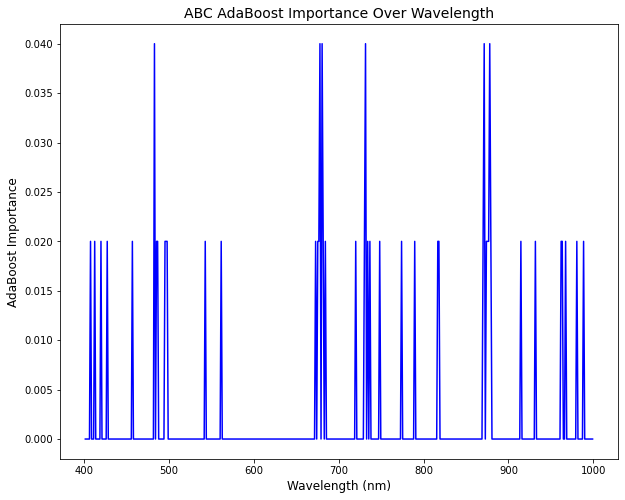

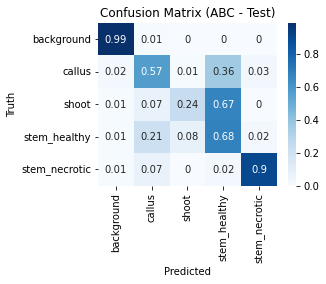

Train

Results shape: (70544,)
Labels shape: (70544,)



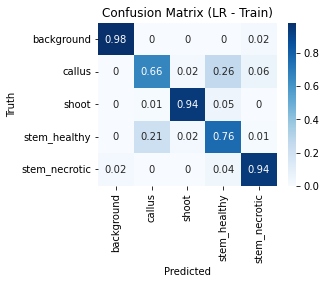

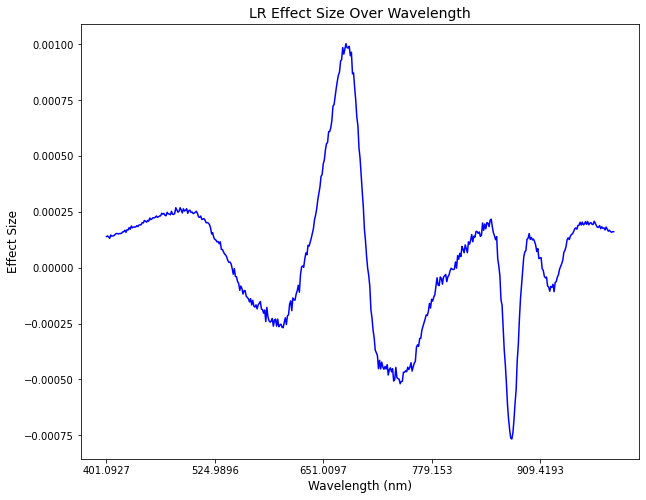

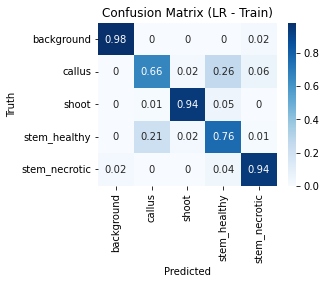

Test

Results shape: (17636,)
Labels shape: (17636,)



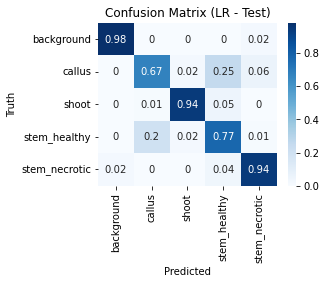

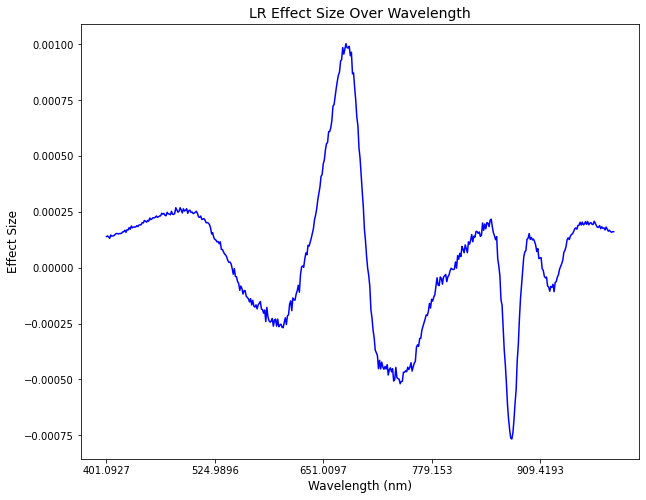

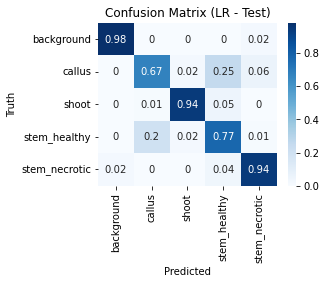

Train

Results shape: (70544,)
Labels shape: (70544,)



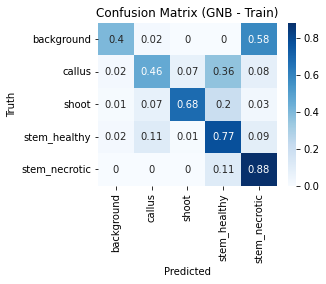

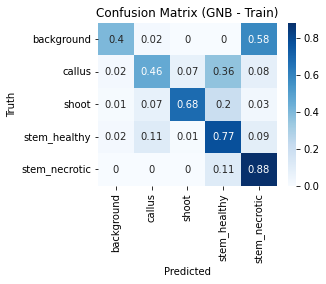

Test

Results shape: (17636,)
Labels shape: (17636,)



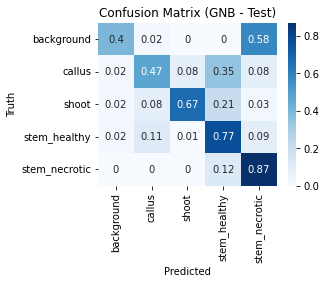

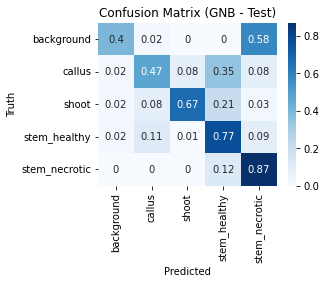

Train

Results shape: (70544,)
Labels shape: (70544,)



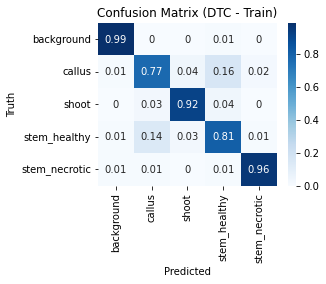

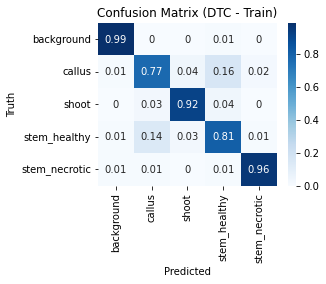

Test

Results shape: (17636,)
Labels shape: (17636,)



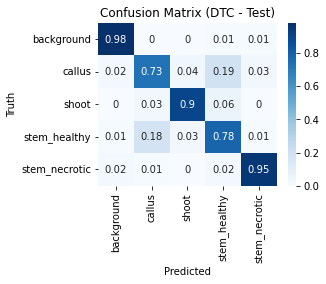

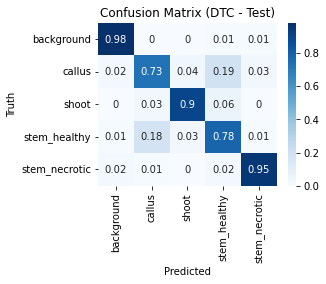

In [9]:
model_types = ["PCA", "LDA", "RF", "GBC", "ABC", "LR", "GNB", "DTC"]
data_types = ["Train", "Test"]

school = CubeSchool(training_data, model_types, colors)
school.run()

## Evaluation and deployment of `CubeLearner` objects

### Confusion matrix heatmaps and other model summary plots

PCA

Results shape: (88180, 2)
Labels shape: (88180,)



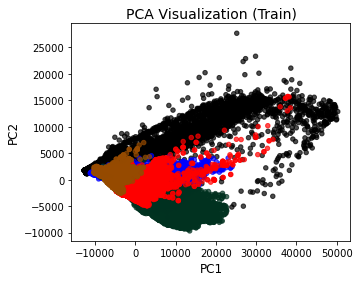

PCA

Results shape: (88180, 2)
Labels shape: (88180,)



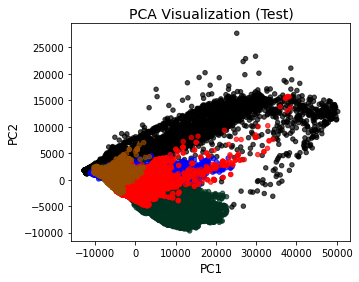

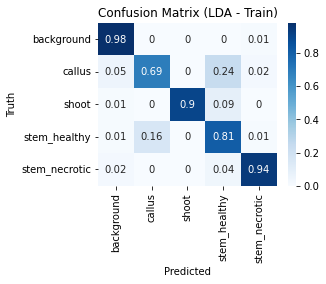

Train

Results shape: (70544, 4)
Labels shape: (70544,)



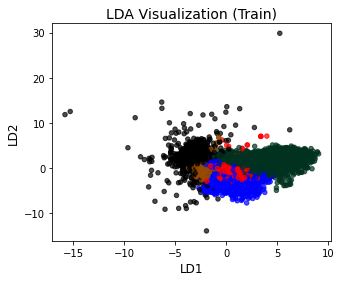

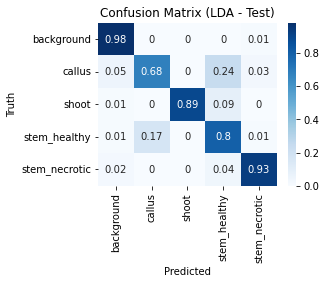

Test

Results shape: (17636, 4)
Labels shape: (17636,)



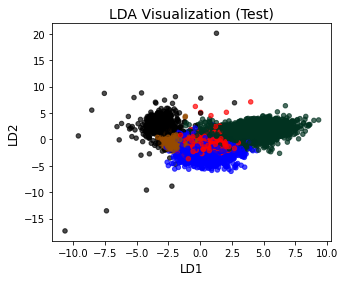

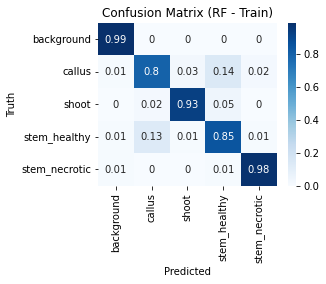

Train

Results shape: (70544,)
Labels shape: (70544,)



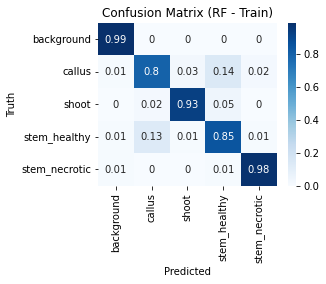

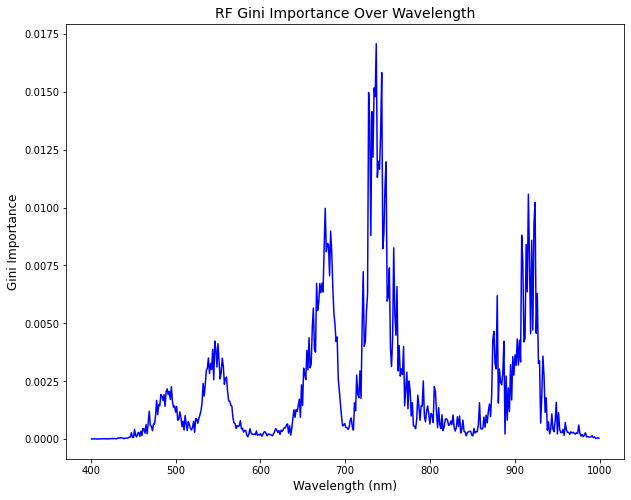

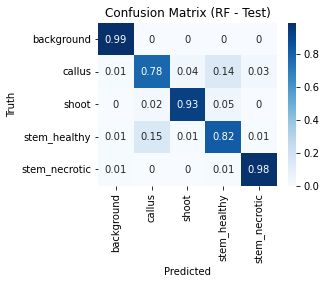

Test

Results shape: (17636,)
Labels shape: (17636,)



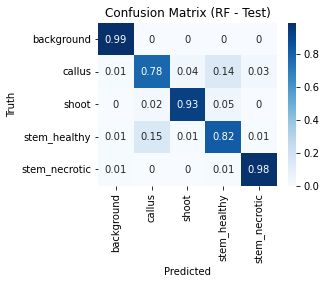

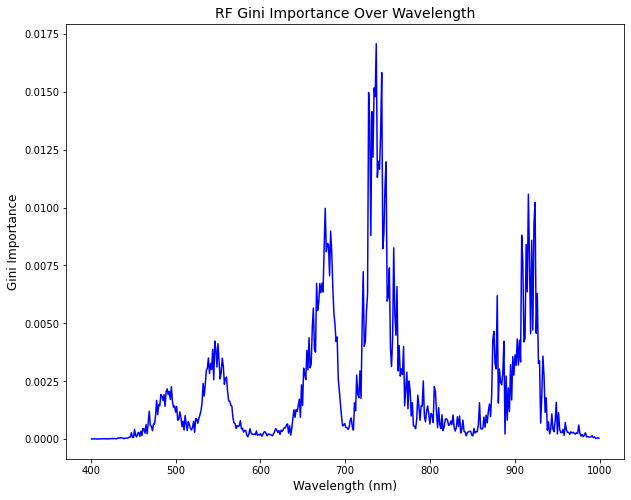

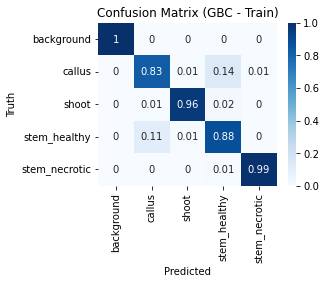

Train

Results shape: (70544,)
Labels shape: (70544,)



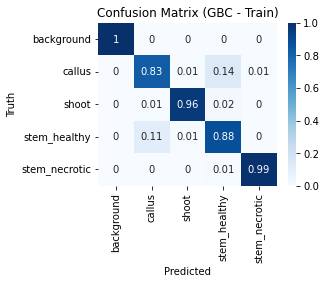

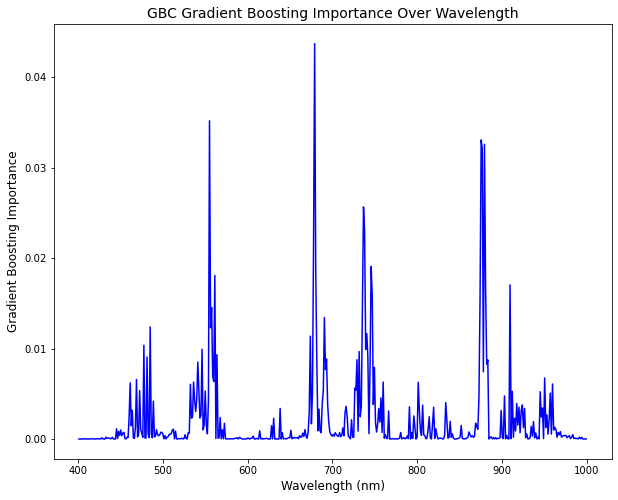

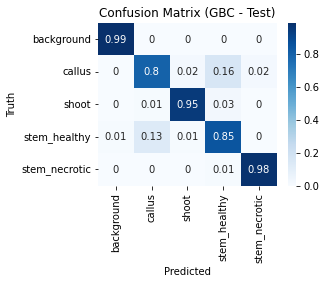

Test

Results shape: (17636,)
Labels shape: (17636,)



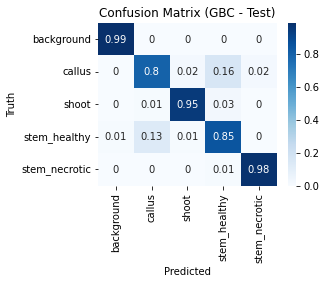

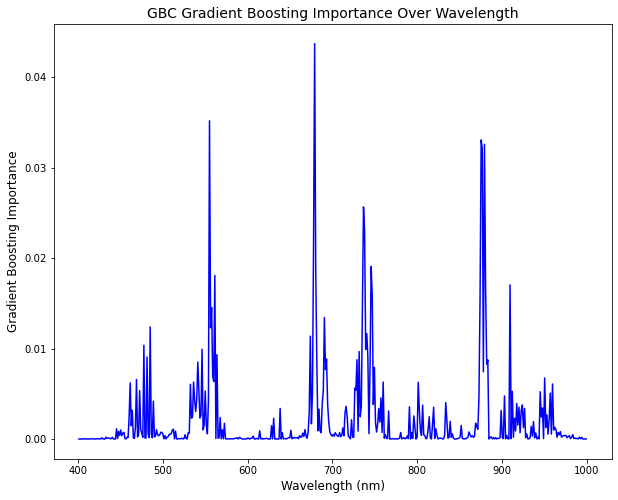

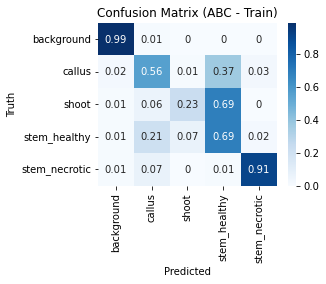

Train

Results shape: (70544,)
Labels shape: (70544,)



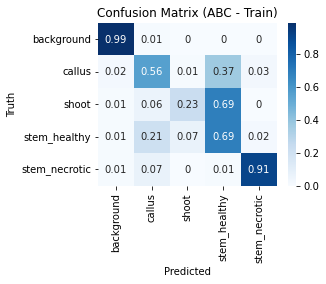

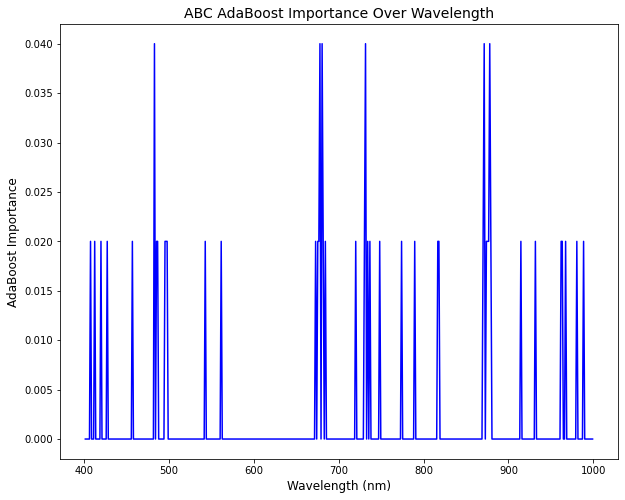

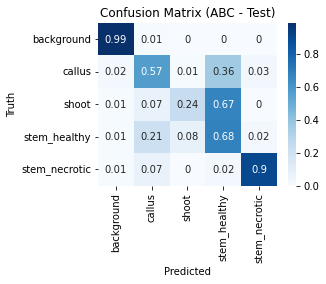

Test

Results shape: (17636,)
Labels shape: (17636,)



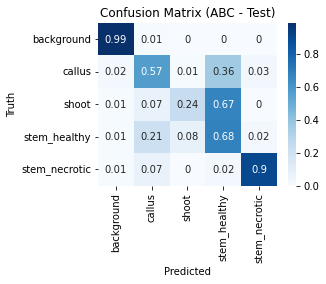

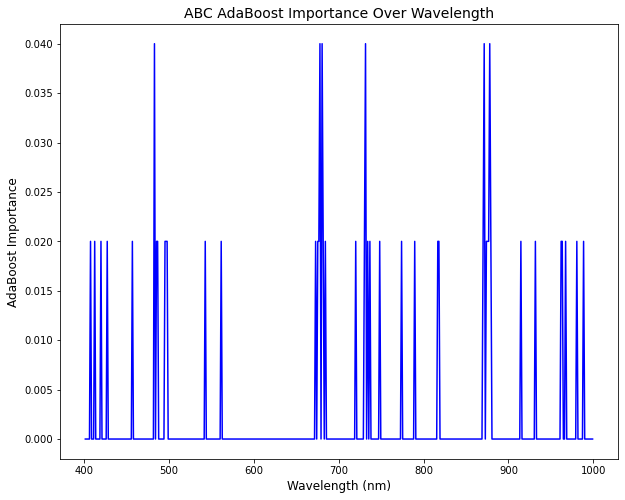

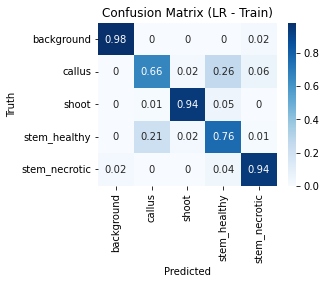

Train

Results shape: (70544,)
Labels shape: (70544,)



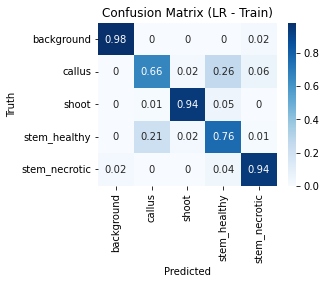

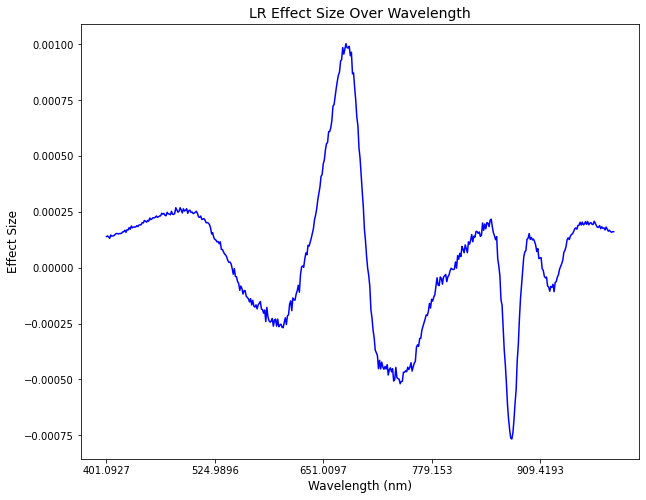

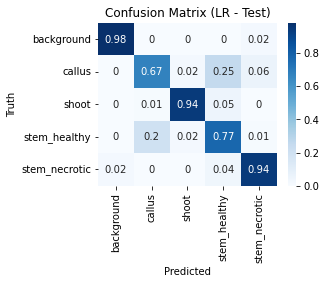

Test

Results shape: (17636,)
Labels shape: (17636,)



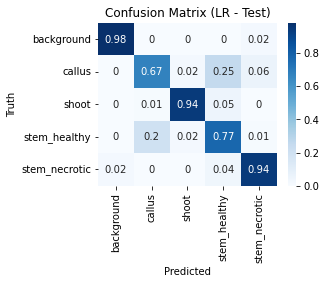

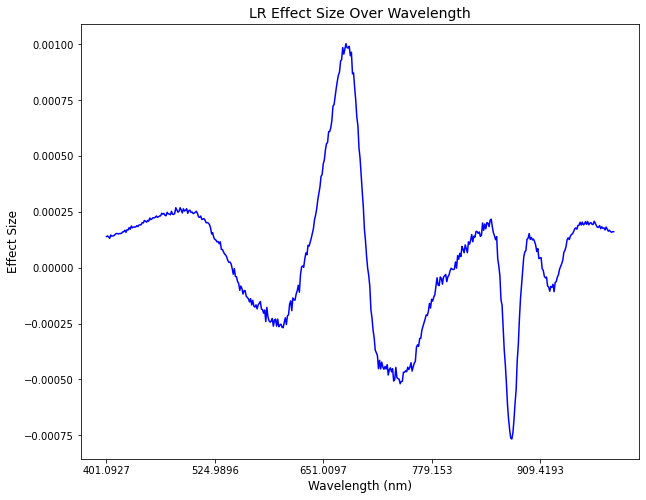

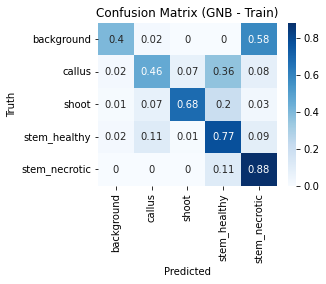

Train

Results shape: (70544,)
Labels shape: (70544,)



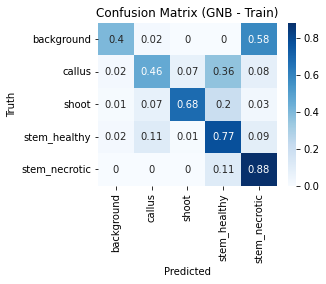

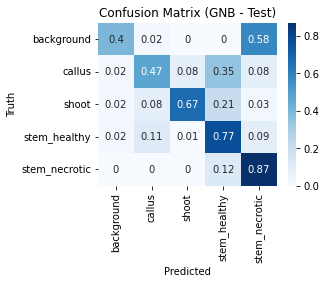

Test

Results shape: (17636,)
Labels shape: (17636,)



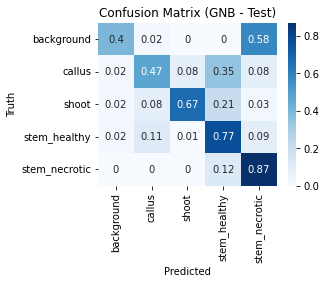

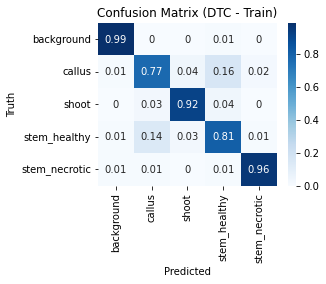

Train

Results shape: (70544,)
Labels shape: (70544,)



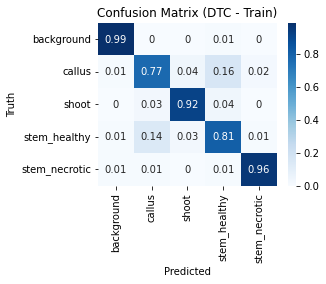

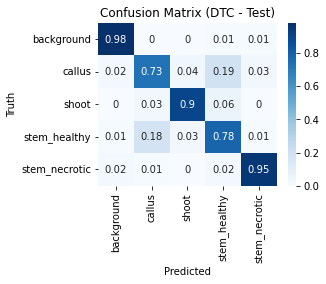

Test

Results shape: (17636,)
Labels shape: (17636,)



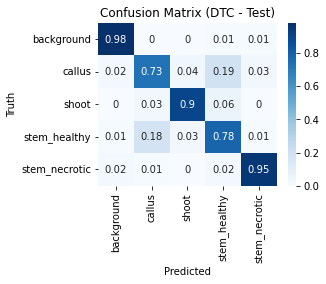

In [10]:
school.multi_plot(output_dir = learner_plot_dir)

### IoU table

In [11]:
table = presentable_table(training_data.labels_key_df, school.iou_dict)
filename = "output/" + os.path.basename(os.path.normpath(png_directory.replace('/', '_metrics.csv')))
table.to_csv(filename)

### Inference plots

In [12]:
df = match_files(hypercube_dir)

In [13]:
model_types.remove("PCA")
generate_falsecolor_images(df = df, 
                           learner_dict = school.learner_dict,
                           model_types = model_types,
                           colors = colors,
                           output_dir = falsecolor_dir, 
                           min_wave = 400, 
                           max_wave = 1000)

load mode isload_full_then_crop


/home/gmobot/anaconda3/envs/cubeglm2/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


load mode isload_full_then_crop


/home/gmobot/anaconda3/envs/cubeglm2/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


load mode isload_full_then_crop


/home/gmobot/anaconda3/envs/cubeglm2/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


load mode isload_full_then_crop


/home/gmobot/anaconda3/envs/cubeglm2/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


load mode isload_full_then_crop


/home/gmobot/anaconda3/envs/cubeglm2/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


load mode isload_full_then_crop


/home/gmobot/anaconda3/envs/cubeglm2/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


load mode isload_full_then_crop


/home/gmobot/anaconda3/envs/cubeglm2/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


load mode isload_full_then_crop


/home/gmobot/anaconda3/envs/cubeglm2/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


load mode isload_full_then_crop


/home/gmobot/anaconda3/envs/cubeglm2/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


load mode isload_full_then_crop


/home/gmobot/anaconda3/envs/cubeglm2/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


load mode isload_full_then_crop


/home/gmobot/anaconda3/envs/cubeglm2/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


load mode isload_full_then_crop


/home/gmobot/anaconda3/envs/cubeglm2/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


load mode isload_full_then_crop


/home/gmobot/anaconda3/envs/cubeglm2/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


load mode isload_full_then_crop


/home/gmobot/anaconda3/envs/cubeglm2/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


load mode isload_full_then_crop


/home/gmobot/anaconda3/envs/cubeglm2/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


load mode isload_full_then_crop


/home/gmobot/anaconda3/envs/cubeglm2/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


load mode isload_full_then_crop


/home/gmobot/anaconda3/envs/cubeglm2/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


load mode isload_full_then_crop


/home/gmobot/anaconda3/envs/cubeglm2/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


load mode isload_full_then_crop


/home/gmobot/anaconda3/envs/cubeglm2/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


load mode isload_full_then_crop


/home/gmobot/anaconda3/envs/cubeglm2/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


load mode isload_full_then_crop


/home/gmobot/anaconda3/envs/cubeglm2/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


In [14]:
import importlib
import sys

In [15]:
# Reload the module
importlib.reload(sys.modules['cubeml.model_evaluation'])

# Re-import the functions
from cubeml.model_evaluation import presentable_table, generate_falsecolor_images, compare_inferences, match_files


In [16]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
from gmodetector_py import Hypercube
from cubeml import CubeLearner
from typing import Union, List

In [17]:
def compare_inferences(df: pd.DataFrame, 
                       num_panels: int = 3,
                       model_types: list = ["LDA", "RF", "GBC", "ABC", "LR", "GNB", "DTC"],
                       falsecolor_dir: str = "output/falsecolor/",
                       output_dir: str = "output/panel_images/"):
    os.makedirs(output_dir, exist_ok=True)

    for _, row in df.iterrows():
        img_id = row['id']
        png = row['png']

        fig, axs = plt.subplots(len(model_types), 1, figsize=(15, len(model_types)*5))
        if len(model_types) == 1:  # Ensure there's only one axis if there's one model_type
            axs = [axs]

        for ax, model_type in zip(axs, model_types):
            print(f"Processing with {model_type} model")
            false_color_file = os.path.join(falsecolor_dir, f"{img_id}_{model_type}.png")
            img = multi_panel_figure(png, false_color_file, num_panels=num_panels)

            ax.imshow(img)
            ax.axis('off')
            ax.text(-0.02, 0.5, model_type, size=36, ha="right", va="center", rotation='vertical', transform=ax.transAxes)

        plt.subplots_adjust(wspace=0.02, hspace=0.02)
        plt.savefig(os.path.join(output_dir, f"{img_id}_panel.png"), dpi=300)
        plt.close(fig)

In [18]:
def multi_panel_figure(png_file, false_color_file, num_panels=3):
    # Open and rotate PNG file
    png = Image.open(png_file).rotate(270, expand=True)

    # Load false color image
    false_color = Image.open(false_color_file)

    # Ensure both images have same size
    if png.size != false_color.size:
        false_color = false_color.resize(png.size)

    # Create overlay of PNG and false color image
    overlay = Image.blend(png.convert('RGBA'), false_color.convert('RGBA'), alpha=0.5)

    # Merge all images together
    if num_panels == 3:
        images = [png, false_color, overlay]
    elif num_panels == 2:
        images = [false_color, overlay]
    else:
        raise ValueError("num_panels must be either 2 or 3")

    # Ensure all images are the same size
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)

    # Create a blank canvas for the final image
    new_img = Image.new('RGBA', (total_width, max_height))

    # Paste each image into the final image
    for idx, img in enumerate(images):
        new_img.paste(img, (widths[idx] * idx, 0))

    # Return the final image
    return new_img


In [19]:
compare_inferences(df = df,
                   model_types = model_types,
                   falsecolor_dir = falsecolor_dir,
                   output_dir = panel_image_dir,
                   num_panels = 3)

Processing with LDA model
Processing with RF model
Processing with GBC model
Processing with ABC model
Processing with LR model
Processing with GNB model
Processing with DTC model
Processing with LDA model
Processing with RF model
Processing with GBC model
Processing with ABC model
Processing with LR model
Processing with GNB model
Processing with DTC model
Processing with LDA model
Processing with RF model
Processing with GBC model
Processing with ABC model
Processing with LR model
Processing with GNB model
Processing with DTC model
Processing with LDA model
Processing with RF model
Processing with GBC model
Processing with ABC model
Processing with LR model
Processing with GNB model
Processing with DTC model
Processing with LDA model
Processing with RF model
Processing with GBC model
Processing with ABC model
Processing with LR model
Processing with GNB model
Processing with DTC model
Processing with LDA model
Processing with RF model
Processing with GBC model
Processing with ABC mod

### `plot_spectra` for `TrainingData`

/tmp/ipykernel_1040245/2139949131.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


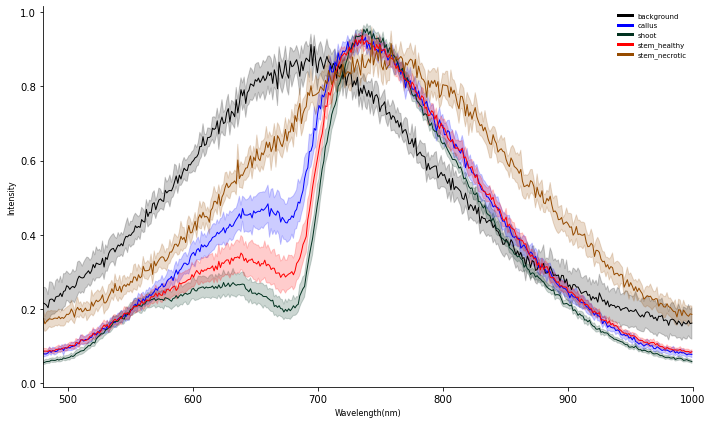

In [10]:
fig = training_data.plot_spectra(colors, sampling_fraction = 0.001)
spectra_filename = png_directory.replace('/', '_spectra.png')
fig.savefig("output/" + spectra_filename)
fig.show()